# **<span style="color:lightgreen;">Scaling, Imputing and Heatmaps with Supervised Learning</span>**

## **Purpose of Notebook**


- Load datasets
- Sample to balance size
- Dummy fill NaNs
- Encode categoricals
- Scale numericals
- Supervised imputation
- Correlation heatmap
- Feature selection (top 10)

---

**Load needed Libraries**

In [57]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_squared_error
)

# Clustering (if needed)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



**Load in the cleaned datasets**

In [58]:
# Display all columns of a pandas DataFrame when printed
pd.set_option('display.max_columns', None)

# US Dataset
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US-cleaned_data.csv')


# UK Dataset
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')

print("US Dataset Shape:", US_data.shape)
print("UK Dataset Shape:", UK_data.shape)

US Dataset Shape: (4372, 21)
UK Dataset Shape: (232365, 21)


In [59]:
# Identify numerical and categorical columns
numerical_columns = ['Posted Speed Limit (MPH)']
categorical_columns = [
    'Make', 'Model', 'Model Year', 'ADS Equipped?',
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 'Country'
]
datetime_columns = ['Incident Date', 'Incident Time (24:00)']
indexing_columns = ['Report ID', 'Report Version']

**Fill in Missing Data**



In [60]:
from prettytable import PrettyTable

# Function to calculate and display missing values
def display_missing_values(dataset, dataset_name):
    features_with_na = [feature for feature in dataset.columns if dataset[feature].isnull().sum() > 0]
    
    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Feature", "Percentage of Missing Values"]
    
    for feature in features_with_na:
        missing_percentage = np.round(dataset[feature].isnull().mean() * 100, 2)
        table.add_row([feature, f"{missing_percentage} %"])
    
    print(f"Missing Values in {dataset_name}:")
    print(table)

# Check missing values for both datasets
display_missing_values(UK_data, "UK Dataset")
display_missing_values(US_data, "US Dataset")


Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
|  Model  |            1.11 %            |
+---------+------------------------------+
Missing Values in US Dataset:
+--------------------------+------------------------------+
|         Feature          | Percentage of Missing Values |
+--------------------------+------------------------------+
|        Model Year        |            0.32 %            |
|      Incident Date       |            0.43 %            |
|  Incident Time (24:00)   |            4.6 %             |
| Posted Speed Limit (MPH) |           11.34 %            |
+--------------------------+------------------------------+


# **Encode Catergorical and Time Series Data**

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_df(df, categorical_columns, datetime_columns):
    data_copy = df.copy()
    data_copy.drop(columns=indexing_columns, inplace=True)

    for col in categorical_columns:
        if col in data_copy.columns:
            le = LabelEncoder()
            data_copy[col] = le.fit_transform(data_copy[col].astype(str))
    
    for col in datetime_columns:
        if col in data_copy.columns:
            le = LabelEncoder()
            data_copy[col] = le.fit_transform(data_copy[col].astype(str))
    return data_copy


**Scale Values**

In [62]:
from sklearn.preprocessing import MinMaxScaler

def scale_df(df):
    scaler = MinMaxScaler()
    scaled_df = df.copy()
    scaled_df[df.columns] = scaler.fit_transform(df)
    return scaled_df


# Check missing values for both datasets
display_missing_values(UK_data, "UK Dataset")
display_missing_values(US_data, "US Dataset")

Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
|  Model  |            1.11 %            |
+---------+------------------------------+
Missing Values in US Dataset:
+--------------------------+------------------------------+
|         Feature          | Percentage of Missing Values |
+--------------------------+------------------------------+
|        Model Year        |            0.32 %            |
|      Incident Date       |            0.43 %            |
|  Incident Time (24:00)   |            4.6 %             |
| Posted Speed Limit (MPH) |           11.34 %            |
+--------------------------+------------------------------+


# **Imputing Methods**
- mean/median/mode
- k Means
- random 
- regression model
- k nearest neighbours
- last occured carried forward

### **Mean, Median, Mode**
- Best for: Small amounts of missing numerical data.
- How it works: Replaces missing values with the mean (for normally distributed data), median (for skewed data), or mode (for categorical variables).
- Limitations: Can distort distributions and underestimate variance.

In [63]:
def mode_mean_imputation(data, numerical_columns, categorical_columns, datetime_columns):
    """
    Impute missing values in numerical and categorical columns using mean for numerical and mode for categorical and datetime.
    
    Parameters:
    - data: DataFrame with missing values
    - numerical_columns: List of numerical columns to impute
    - categorical_columns: List of categorical columns to impute
    - datetime_columns: List of datetime columns to impute
    
    Returns:
    - DataFrame with imputed values
    """
    # Impute numerical columns with mean
    for col in numerical_columns:
        if col in data.columns:
            data[col].fillna(data[col].mean(), inplace=True)
    
    # Impute categorical columns with mode
    for col in categorical_columns:
        if col in data.columns:
            data[col].fillna(data[col].mode()[0], inplace=True)
    
    # Impute datetime columns with mode
    for col in datetime_columns:
        if col in data.columns:
            data[col].fillna(data[col].mode()[0], inplace=True)
    
    return data

mode_imputed_df = mode_mean_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
from tabulate import tabulate

print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))





+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/2025267401.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/2025267401.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

### **Random Imputation**
- **Best for:** Maintaining original distribution with enough data  
- **How it works:** Replaces missing by random sampling from existing values  
- **Limitations:** Adds randomness; may create unrealistic combinations  


In [64]:
import numpy as np

def random_imputation(data, numerical_columns, categorical_columns, datetime_columns):
    """
    Impute missing values by randomly sampling from non-missing values in each column.
    
    Parameters:
    - data: DataFrame with missing values
    - numerical_columns: List of numerical columns to impute
    - categorical_columns: List of categorical columns to impute
    - datetime_columns: List of datetime columns to impute
    
    Returns:
    - DataFrame with imputed values
    """
    for col in numerical_columns + categorical_columns + datetime_columns:
        if col in data.columns:
            non_null_values = data[col].dropna().values
            # Only impute if there are missing values and non-null values exist
            if data[col].isnull().sum() > 0 and len(non_null_values) > 0:
                # Randomly choose from non-null values to fill missing
                random_samples = np.random.choice(non_null_values, size=data[col].isnull().sum(), replace=True)
                data.loc[data[col].isnull(), col] = random_samples
                
    return data

# Use your data and columns as before
mode_imputed_df = random_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)

from tabulate import tabulate
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))


+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **Last Occurance Imputation**
- **Best for:** Maintaining original distribution with enough data  
- **How it works:** Replaces missing by random sampling from existing values  
- **Limitations:** Adds randomness; may create unrealistic combinations  


In [65]:
def last_occurrence_imputation(data, numerical_columns, categorical_columns, datetime_columns):
    """
    Impute missing values using backward fill (last occurrence) for numerical, categorical, and datetime columns.
    
    Parameters:
    - data: DataFrame with missing values
    - numerical_columns: List of numerical columns to impute
    - categorical_columns: List of categorical columns to impute
    - datetime_columns: List of datetime columns to impute
    
    Returns:
    - DataFrame with imputed values
    """
    for col in numerical_columns + categorical_columns + datetime_columns:
        if col in data.columns:
            data[col].fillna(method='bfill', inplace=True)
            
    return data

# Usage example
mode_imputed_df = last_occurrence_imputation(US_data, numerical_columns, categorical_columns, datetime_columns)

from tabulate import tabulate
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))


+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/643073262.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(method='bfill', inplace=True)
/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/643073262.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(method='bfill', inplace=True)


### Regression Imputer
- **Best for:** When strong relationships exist between features  
- **How it works:** Predicts missing values using regression models on other features  
- **Limitations:** Assumes linearity; risk of overfitting if data is small  

In [66]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import pandas as pd
from tabulate import tabulate

regression_df = US_data.copy()
# Impute only numerical columns
imputer = IterativeImputer(random_state=0)
imputed_array = imputer.fit_transform(regression_df[numerical_columns])
imputed_numerical_df = pd.DataFrame(imputed_array, columns=numerical_columns)

# For categorical: fill with mode or use another strategy
imputed_categorical_df = regression_df[categorical_columns].fillna(regression_df[categorical_columns].mode().iloc[0])

# For datetime: forward fill as an example
imputed_datetime_df = regression_df[datetime_columns].fillna(method='ffill')
imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df, imputed_datetime_df], axis=1)
print(tabulate(imputed_df.head(), headers='keys', tablefmt='psql'))


+----+----------------------------+---------------+---------+--------------+-----------------+------------------------------+--------------------+---------+-------------------+-------------------+--------------------+--------------------+-----------------------------------+-------------------------+--------------------------------+-----------+-----------+-----------------+-------------------------+
|    |   Posted Speed Limit (MPH) | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | City               | State   | Roadway Type      | Roadway Surface   | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | SV Contact Area                | Weather   | Country   | Incident Date   | Incident Time (24:00)   |
|----+----------------------------+---------------+---------+--------------+-----------------+------------------------------+--------------------+---------+-------------------+-------------------+

/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/1622105651.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imputed_datetime_df = regression_df[datetime_columns].fillna(method='ffill')


### **Comparison of Imputer Qualities**

**Create a controlled test set with known missing values**
- To fairly compare imputers, you need to:
- Select a subset of your complete dataset with no missing values.
- Introduce missing values artificially (e.g., 10% randomly) so you know the ground truth.

**Numerical Columns**

In [67]:

# 1. Drop rows with missing values to get clean baseline
complete_data = data_copy_scaled.dropna()
numerical_data = complete_data[numerical_columns]

# 2. Randomly mask 20% of numerical values
data_masked = numerical_data.copy()
mask = np.random.rand(*data_masked.shape) < 0.2
data_masked = data_masked.mask(mask)

# 3. Imputation Methods
# Mean
mean_imp = SimpleImputer(strategy='mean')
mean_result = pd.DataFrame(mean_imp.fit_transform(data_masked), columns=numerical_columns)

# Mode
mode_imp = SimpleImputer(strategy='most_frequent')
mode_result = pd.DataFrame(mode_imp.fit_transform(data_masked), columns=numerical_columns)

# Regression
reg_imp = IterativeImputer(random_state=0)
reg_result = pd.DataFrame(reg_imp.fit_transform(data_masked), columns=numerical_columns)

# Last Occurrence (Forward Fill)
last_occurrence_result = data_masked.fillna(method='ffill')

# Random Imputation
random_result = data_masked.copy()
for col in numerical_columns:
    missing_idx = random_result[col].isna()
    if missing_idx.any():
        random_sample = random_result[col].dropna().sample(missing_idx.sum(), replace=True, random_state=0).values
        random_result.loc[missing_idx, col] = random_sample

# 4. RMSE calculation at only the masked (missing) positions
def masked_rmse(imputed, original, mask):
    rmse_total = 0
    n = 0
    for i, col in enumerate(numerical_columns):
        col_mask = mask[:, i]
        if np.any(col_mask):
            mse = mean_squared_error(original[col_mask, i], imputed[col_mask, i])
            rmse_total += np.sqrt(mse)
            n += 1
    return rmse_total / n

# 5. Convert to arrays
original_array = numerical_data.values
mean_array = mean_result.values
mode_array = mode_result.values
reg_array = reg_result.values
last_occ_array = last_occurrence_result.values
random_array = random_result.values

# 6. Compute RMSE for each method
rmse_scores = {
    "Mean": masked_rmse(mean_array, original_array, mask),
    "Mode": masked_rmse(mode_array, original_array, mask),
    "Regression": masked_rmse(reg_array, original_array, mask),
    "Last Occurrence": masked_rmse(last_occ_array, original_array, mask),
    "Random": masked_rmse(random_array, original_array, mask)
}

# 7. Print results
table_data = [[method, f"{score:.4f}"] for method, score in rmse_scores.items()]
print(tabulate(table_data, headers=["Imputation Method", "RMSE Score"], tablefmt="psql"))



+---------------------+--------------+
| Imputation Method   |   RMSE Score |
|---------------------+--------------|
| Mean                |       0.222  |
| Mode                |       0.3123 |
| Regression          |       0.222  |
| Last Occurrence     |       0.2092 |
| Random              |       0.3161 |
+---------------------+--------------+


/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/263511584.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  last_occurrence_result = data_masked.fillna(method='ffill')


**Catergorical Columns**

In [68]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from tabulate import tabulate

US_data = US_data.copy()
# ----------------------------------------------
# 1. Drop rows with missing values in categorical columns to get clean baseline
complete_data = US_data.dropna(subset=categorical_columns)

categorical_data = complete_data[categorical_columns]

# ----------------------------------------------
# 2. Randomly mask 20% of categorical data
data_masked = categorical_data.copy()
mask = np.random.rand(*data_masked.shape) < 0.2
data_masked = data_masked.mask(mask)

# ----------------------------------------------
# 3. Imputation Methods

# Mode imputation
mode_imp = SimpleImputer(strategy='most_frequent')
mode_result = pd.DataFrame(mode_imp.fit_transform(data_masked), columns=categorical_columns)

# Forward fill imputation (with backward fill to handle NaNs at top)
last_occurrence_result = data_masked.ffill().bfill()

# Random imputation
random_result = data_masked.copy()
for col in categorical_columns:
    missing_idx = random_result[col].isna()
    if missing_idx.any():
        random_sample = random_result[col].dropna().sample(missing_idx.sum(), replace=True, random_state=0).values
        random_result.loc[missing_idx, col] = random_sample

# ----------------------------------------------
# 4. Encode categorical columns as integers for accuracy calculation
def encode_df(df):
    encoded_df = pd.DataFrame()
    encoders = {}
    for col in categorical_columns:
        encoded_df[col], encoders[col] = pd.factorize(df[col])
    return encoded_df, encoders

original_encoded, encoders = encode_df(categorical_data)
mode_encoded, _ = encode_df(mode_result)
last_occ_encoded, _ = encode_df(last_occurrence_result)
random_encoded, _ = encode_df(random_result)

# ----------------------------------------------
# 5. Calculate accuracy at masked positions
def masked_accuracy(imputed, original, mask):
    total_acc = 0
    n = 0
    for i, col in enumerate(categorical_columns):
        col_mask = mask[:, i]
        if np.any(col_mask):
            acc = accuracy_score(original[col_mask, i], imputed[col_mask, i])
            total_acc += acc
            n += 1
    return total_acc / n

# Convert mask DataFrame to numpy array if needed
mask_array = mask.values if isinstance(mask, pd.DataFrame) else mask

# ----------------------------------------------
# 6. Calculate accuracy scores for each imputation method
accuracy_scores = {
    "Mode": masked_accuracy(mode_encoded.values, original_encoded.values, mask_array),
    "Last Occurrence": masked_accuracy(last_occ_encoded.values, original_encoded.values, mask_array),
    "Random": masked_accuracy(random_encoded.values, original_encoded.values, mask_array)
}

# ----------------------------------------------
# 7. Print results in table format
table_data = [[method, f"{score:.4f}"] for method, score in accuracy_scores.items()]
print(tabulate(table_data, headers=["Imputation Method", "Accuracy Score"], tablefmt="psql"))



+---------------------+------------------+
| Imputation Method   |   Accuracy Score |
|---------------------+------------------|
| Mode                |           0.324  |
| Last Occurrence     |           0.3926 |
| Random              |           0.2639 |
+---------------------+------------------+


**Date Time columns**

In [69]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from tabulate import tabulate

US_data = US_data.copy()

# ----------------------------------------------
# 1. Drop rows with missing values in datetime columns to get clean baseline
complete_data = US_data.dropna(subset=datetime_columns)

# Select categorical columns from the cleaned data
categorical_data = complete_data[categorical_columns]

# ----------------------------------------------
# 2. Randomly mask 20% of categorical data
data_masked = categorical_data.copy()
mask = np.random.rand(*data_masked.shape) < 0.2
data_masked = data_masked.mask(mask)

# ----------------------------------------------
# 3. Imputation Methods

# Mode imputation
mode_imp = SimpleImputer(strategy='most_frequent')
mode_result = pd.DataFrame(mode_imp.fit_transform(data_masked), columns=categorical_columns)

# Forward fill imputation (with backward fill to handle NaNs at top)
last_occurrence_result = data_masked.ffill().bfill()

# Random imputation
random_result = data_masked.copy()
for col in categorical_columns:
    missing_idx = random_result[col].isna()
    if missing_idx.any():
        random_sample = random_result[col].dropna().sample(missing_idx.sum(), replace=True, random_state=0).values
        random_result.loc[missing_idx, col] = random_sample

# ----------------------------------------------
# 4. Encode categorical columns as integers for accuracy calculation
def encode_df(df):
    encoded_df = pd.DataFrame()
    encoders = {}
    for col in categorical_columns:
        encoded_df[col], encoders[col] = pd.factorize(df[col])
    return encoded_df, encoders

original_encoded, encoders = encode_df(categorical_data)
mode_encoded, _ = encode_df(mode_result)
last_occ_encoded, _ = encode_df(last_occurrence_result)
random_encoded, _ = encode_df(random_result)

# ----------------------------------------------
# 5. Calculate accuracy at masked positions
def masked_accuracy(imputed, original, mask):
    total_acc = 0
    n = 0
    for i, col in enumerate(categorical_columns):
        col_mask = mask[:, i]
        if np.any(col_mask):
            acc = accuracy_score(original[col_mask, i], imputed[col_mask, i])
            total_acc += acc
            n += 1
    return total_acc / n

# Convert mask DataFrame to numpy array if needed
mask_array = mask.values if isinstance(mask, pd.DataFrame) else mask

# ----------------------------------------------
# 6. Calculate accuracy scores for each imputation method
accuracy_scores = {
    "Mode": masked_accuracy(mode_encoded.values, original_encoded.values, mask_array),
    "Last Occurrence": masked_accuracy(last_occ_encoded.values, original_encoded.values, mask_array),
    "Random": masked_accuracy(random_encoded.values, original_encoded.values, mask_array)
}

# ----------------------------------------------
# 7. Print results in table format
table_data = [[method, f"{score:.4f}"] for method, score in accuracy_scores.items()]
print(tabulate(table_data, headers=["Imputation Method", "Accuracy Score"], tablefmt="psql"))


+---------------------+------------------+
| Imputation Method   |   Accuracy Score |
|---------------------+------------------|
| Mode                |           0.395  |
| Last Occurrence     |           0.4905 |
| Random              |           0.2869 |
+---------------------+------------------+


### **Final Imputations**

For US 
- Numerical = Last Occurance
- Catergorical = Last Occurance
- Datetime = Last Occurance

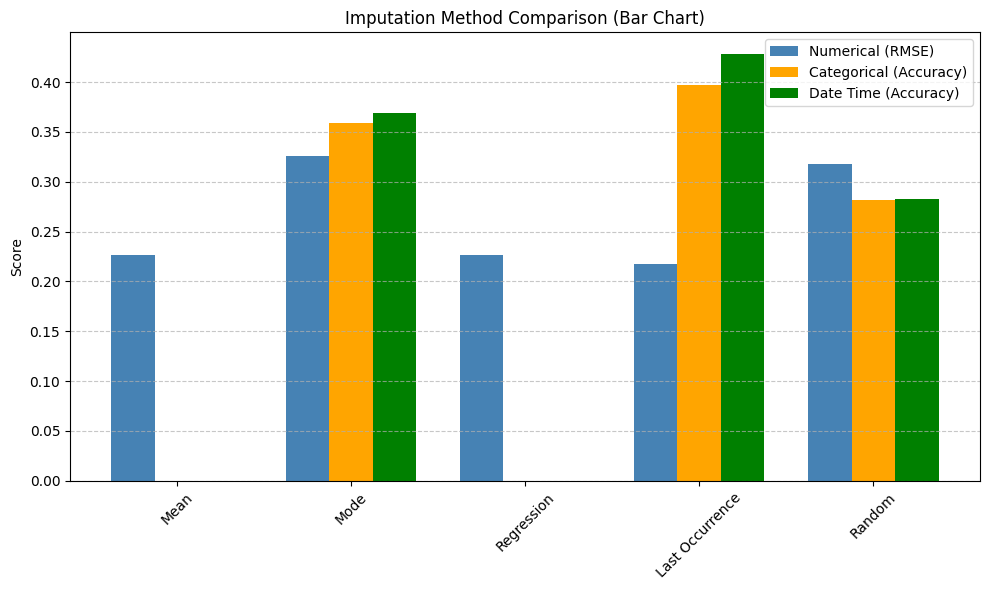

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['Mean', 'Mode', 'Regression', 'Last Occurrence', 'Random']
numerical_scores = [0.2266, 0.3261, 0.2266, 0.2173, 0.318]
categorical_scores = [None, 0.3594, None, 0.3973, 0.2812]
datetime_scores = [None, 0.3688, None, 0.4285, 0.2828]

# Convert None to np.nan for plotting
categorical_scores = [np.nan if x is None else x for x in categorical_scores]
datetime_scores = [np.nan if x is None else x for x in datetime_scores]

# Bar width and positions
x = np.arange(len(methods))
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, numerical_scores, width, label='Numerical (RMSE)', color='steelblue')
ax.bar(x, categorical_scores, width, label='Categorical (Accuracy)', color='orange')
ax.bar(x + width, datetime_scores, width, label='Date Time (Accuracy)', color='green')

# Customizing plot
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45)
ax.set_ylabel('Score')
ax.set_title('Imputation Method Comparison (Bar Chart)')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Final Imputed Datasets
def last_occurrence_imputation(data, numerical_columns, categorical_columns, datetime_columns):
    """
    Impute missing values using backward fill (last occurrence) for numerical, categorical, and datetime columns.
    
    Parameters:
    - data: DataFrame with missing values
    - numerical_columns: List of numerical columns to impute
    - categorical_columns: List of categorical columns to impute
    - datetime_columns: List of datetime columns to impute
    
    Returns:
    - DataFrame with imputed values
    """
    for col in numerical_columns + categorical_columns + datetime_columns:
        if col in data.columns:
            data[col].fillna(method='bfill', inplace=True)
            
    return data

# Usage example
final_US_data = last_occurrence_imputation(US_data, numerical_columns, categorical_columns, datetime_columns)

from tabulate import tabulate
print(tabulate(final_US_data.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/714738544.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(method='bfill', inplace=True)
/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/714738544.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(method='bfill', inplace=True)


In [72]:
# Check missing values for both datasets
display_missing_values(UK_data, "UK Dataset")
display_missing_values(US_data, "US Dataset")

Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
|  Model  |            1.11 %            |
+---------+------------------------------+
Missing Values in US Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
+---------+------------------------------+


## **Outliers**

**DBSCAN and KMeans**

Too few DBSCAN clusters to compute silhouette score.


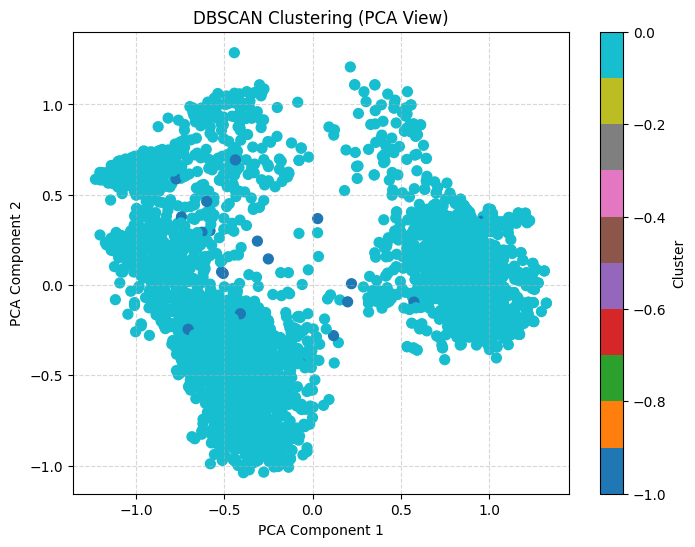

In [85]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# --- Step 3: Apply pipeline ---
encoded_df = encode_df(final_US_data, categorical_columns, datetime_columns)
data_imputed = scale_df(encoded_df)

# --- Step 4: DBSCAN clustering ---
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='hamming')
dbscan_labels = dbscan.fit_predict(data_imputed)

# Silhouette Score for DBSCAN
unique_db_labels = set(dbscan_labels)
if len(unique_db_labels - {-1}) > 1:
    dbscan_score = silhouette_score(data_imputed, dbscan_labels, metric='hamming')
    print("DBSCAN Silhouette Score:", dbscan_score)
else:
    print("Too few DBSCAN clusters to compute silhouette score.")

# --- Step 6: PCA for Visualization ---
pca = PCA(n_components=5)
data_2d = pca.fit_transform(data_imputed)

# Plot DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=dbscan_labels, cmap='tab10', s=50)
plt.title("DBSCAN Clustering (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



KMeans Silhouette Score: 0.28516970704538774


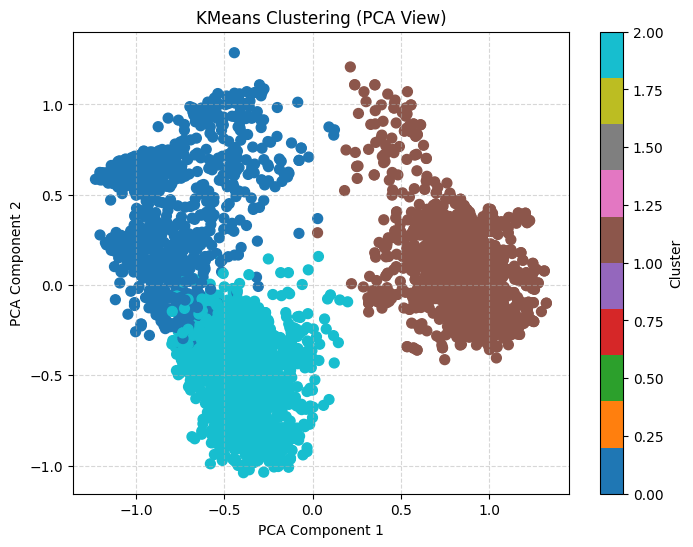

In [83]:

# --- Step 5: KMeans clustering ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_imputed)

# Silhouette Score for KMeans
if len(set(kmeans_labels)) > 1:
    kmeans_score = silhouette_score(data_imputed, kmeans_labels)
    print("KMeans Silhouette Score:", kmeans_score)
else:
    print("Too few KMeans clusters to compute silhouette score.")

# Plot KMeans
plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans_labels, cmap='tab10', s=50)
plt.title("KMeans Clustering (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Silhouette Score: -0.02654271152860101


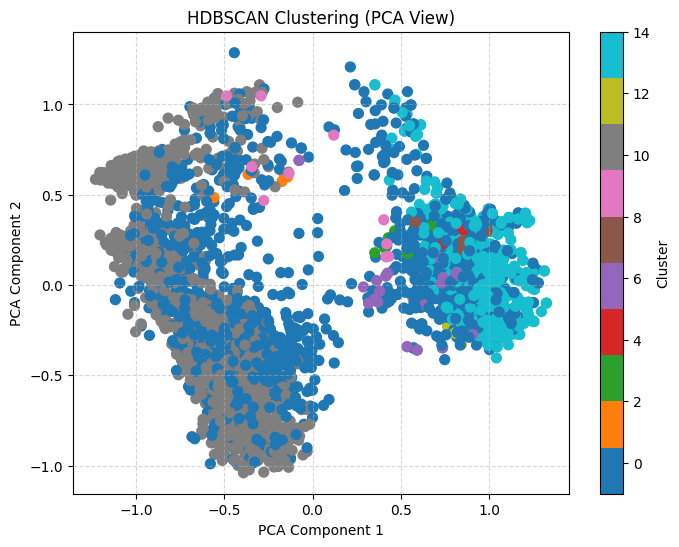

In [86]:
import hdbscan

# --- Step 7: HDBSCAN clustering ---
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='hamming')
hdbscan_labels = hdbscan_clusterer.fit_predict(data_imputed)

# Silhouette Score for HDBSCAN
unique_hdb_labels = set(hdbscan_labels)
if len(unique_hdb_labels - {-1}) > 1:
    hdbscan_score = silhouette_score(data_imputed, hdbscan_labels, metric='hamming')
    print("HDBSCAN Silhouette Score:", hdbscan_score)
else:
    print("Too few HDBSCAN clusters to compute silhouette score.")

# Plot HDBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=hdbscan_labels, cmap='tab10', s=50)
plt.title("HDBSCAN Clustering (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## **Sampling**

**KNN**

**Cluster Sampling Kmeans**

In [98]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors


data = data_imputed.copy()


# --- Encoding categorical columns for KNN and evaluation ---
categorical_cols = data.select_dtypes(include=['object']).columns

# Encode categorical columns using LabelEncoder
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# Now all columns are numeric or encoded numeric

# 1. Random Sampling (20%)
random_sample = data.sample(frac=0.2, random_state=42)

# 2. Systematic Sampling (every 5th item after random start)
start = np.random.randint(0, 5)
systematic_sample = data.iloc[start::5, :]

# 3. Stratified Sampling (20% from each label group)
stratified_sample = data.groupby('Highest Injury Severity Alleged', group_keys=False).apply(
    lambda x: x.sample(frac=0.2, random_state=42))

# 4. Cluster Sampling
clusters = data['Highest Injury Severity Alleged'].unique()
chosen_cluster = np.random.choice(clusters)
cluster_sample = data[data['Highest Injury Severity Alleged'] == chosen_cluster]

# 5. KNN Sampling: Select 20% samples closest to a random point
knn_fraction = 0.2
X = data.values
random_point = X[np.random.choice(len(X))]
nbrs = NearestNeighbors(n_neighbors=int(len(X)*knn_fraction)).fit(X)
distances, indices = nbrs.kneighbors([random_point])
knn_sample = data.iloc[indices[0]]




/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_10596/1540227507.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = data.groupby('Highest Injury Severity Alleged', group_keys=False).apply(


Random Sampling:


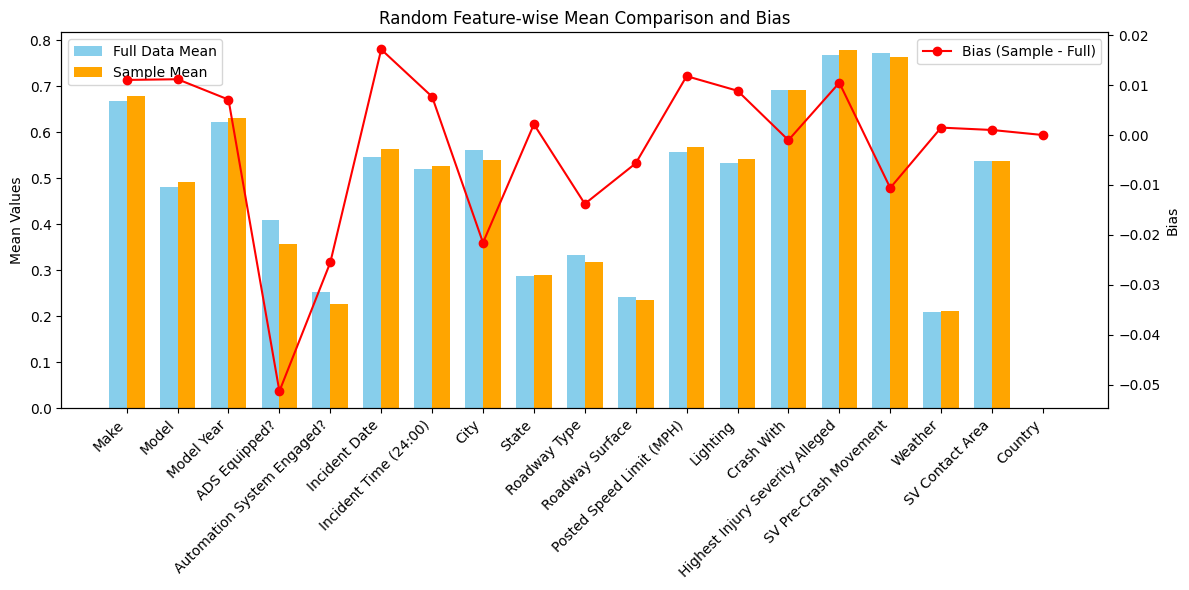

Systematic Sampling:


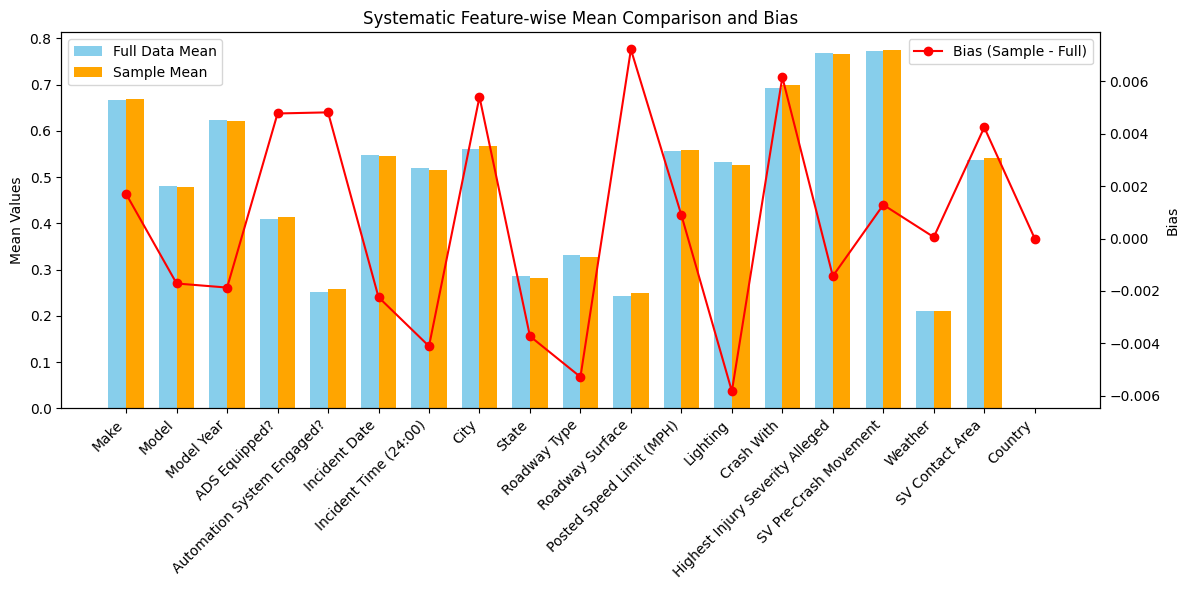

Stratified Sampling:


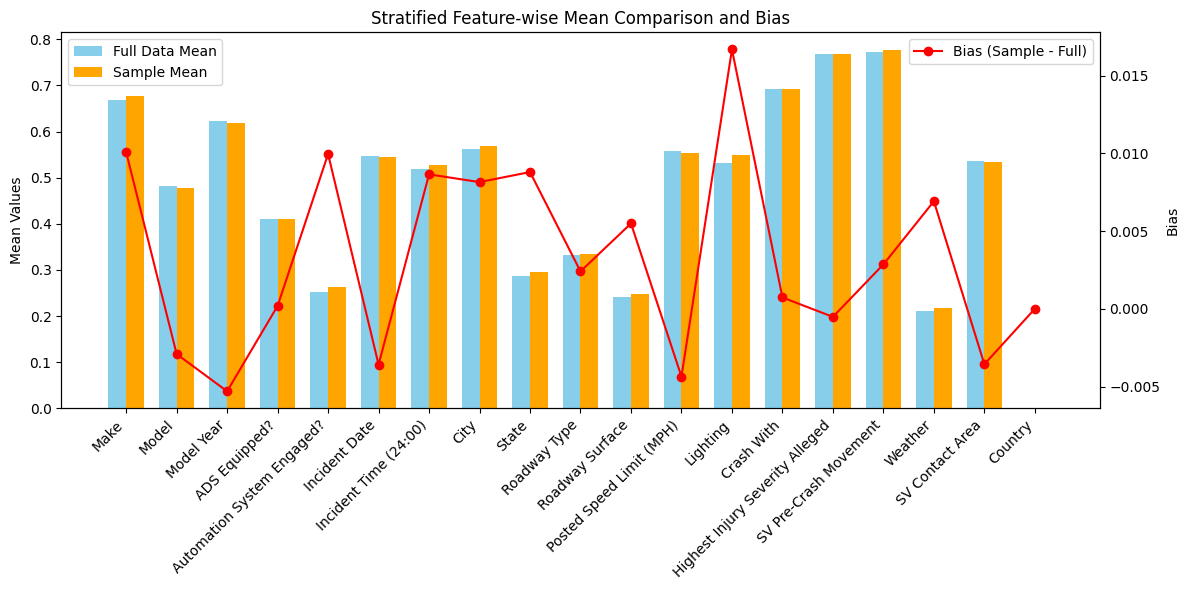

Cluster Sampling (cluster '0.2'):


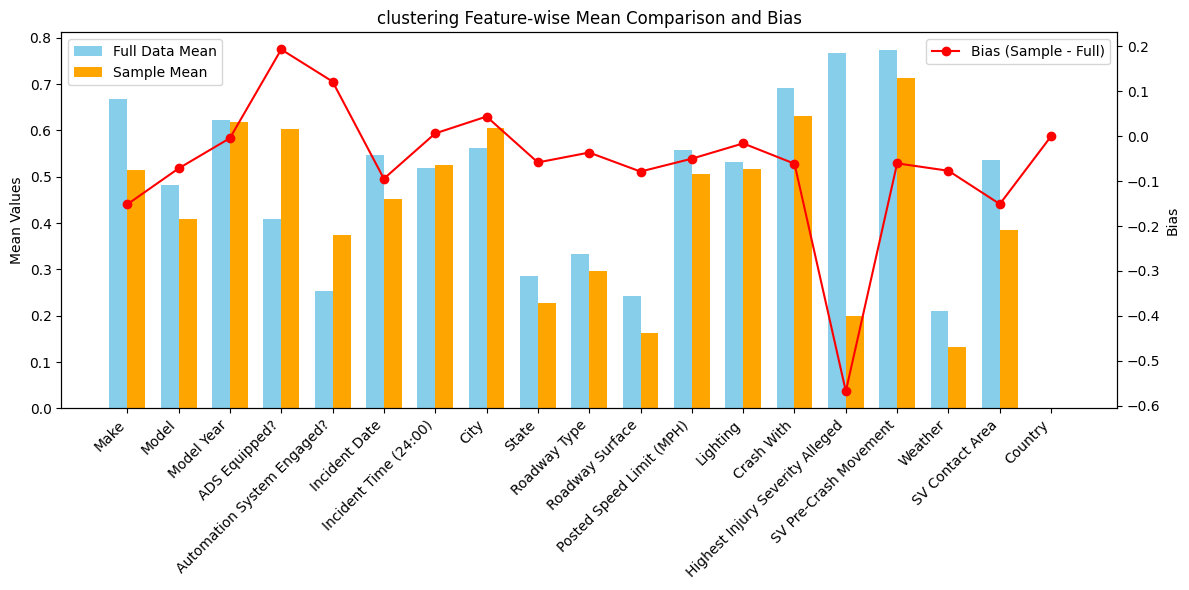

KNN Sampling:


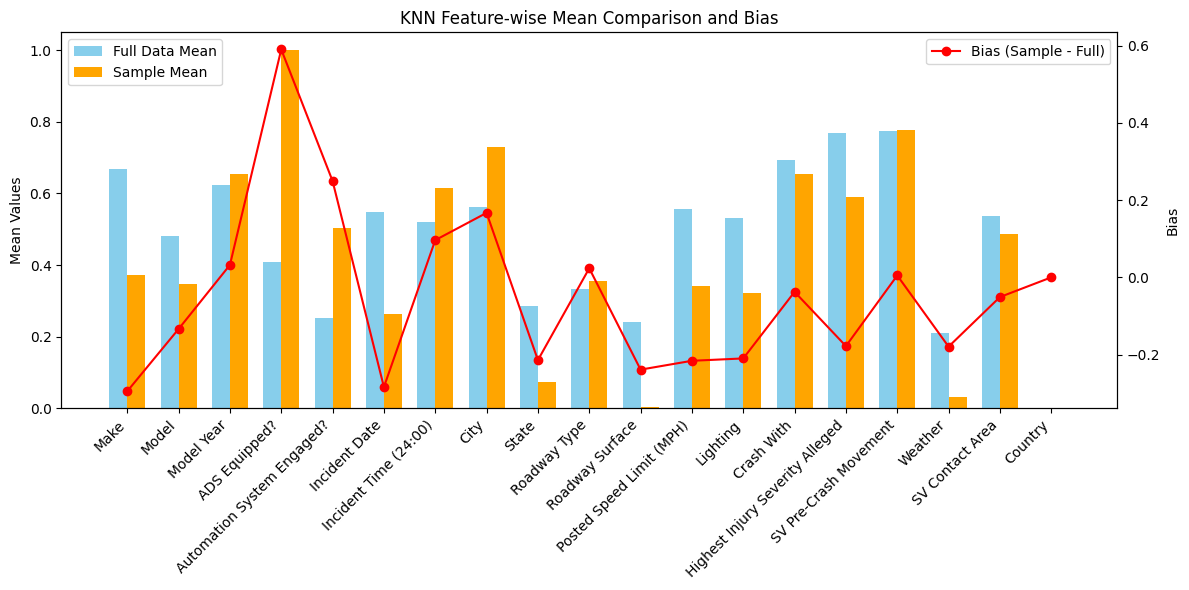

In [102]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_sample(sample, full_data,name):
    means_full = full_data.mean()
    means_sample = sample.mean()
    bias = means_sample - means_full
    
    features = full_data.columns
    
    x = np.arange(len(features))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    # Bar plots for means
    rects1 = ax1.bar(x - width/2, means_full, width, label='Full Data Mean', color='skyblue')
    rects2 = ax1.bar(x + width/2, means_sample, width, label='Sample Mean', color='orange')
    ax1.set_ylabel('Mean Values')
    ax1.set_xticks(x)
    ax1.set_xticklabels(features, rotation=45, ha='right')
    ax1.legend(loc='upper left')
    
    # Line plot for bias on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(x, bias, color='red', marker='o', linestyle='-', label='Bias (Sample - Full)')
    ax2.set_ylabel('Bias')
    ax2.legend(loc='upper right')
    
    plt.title(f'{name}Feature-wise Mean Comparison and Bias')
    plt.tight_layout()
    plt.show()

# --- Evaluation function to compare all features ---

print("Random Sampling:")
evaluate_sample(random_sample, data, "Random ")

print("Systematic Sampling:")
evaluate_sample(systematic_sample, data, "Systematic ")

print("Stratified Sampling:")
evaluate_sample(stratified_sample, data, "Stratified ")

print(f"Cluster Sampling (cluster '{chosen_cluster}'):")
evaluate_sample(cluster_sample, data, "clustering ")

print("KNN Sampling:")
evaluate_sample(knn_sample, data, "KNN ")



**Choosing Systematic Sampling**

In [105]:
# 2. Systematic Sampling (every 5th item after random start)
start = np.random.randint(0, 5)
systematic_sample_df = data.iloc[start::5, :]
systematic_sample_df.head()


,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
4,0.397059,0.502283,0.666667,0.0,1.0,0.981132,0.325740,0.593905,0.901961,0.0,0.00,0.8750,0.666667,0.533333,0.6,0.8125,0.000,0.272727,0.0
9,0.073529,0.022831,0.666667,0.0,1.0,0.688679,0.539104,0.944720,0.647059,0.0,0.75,0.9375,1.000000,0.200000,0.2,0.8125,0.625,0.727273,0.0
14,0.073529,0.995434,0.750000,0.0,0.0,0.641509,0.234624,0.555634,0.588235,0.0,0.00,0.3750,0.666667,0.533333,0.6,0.5625,0.000,0.250000,0.0
19,0.073529,0.977169,0.833333,0.0,1.0,0.849057,0.716021,0.555634,0.058824,0.0,0.75,0.3750,1.000000,0.666667,0.6,0.8125,0.625,0.227273,0.0
24,0.073529,0.986301,0.833333,0.0,1.0,0.952830,0.957479,0.555634,0.058824,0.0,0.75,0.3750,0.000000,0.533333,0.6,0.8125,0.000,0.227273,0.0


## **Create Heatmap**

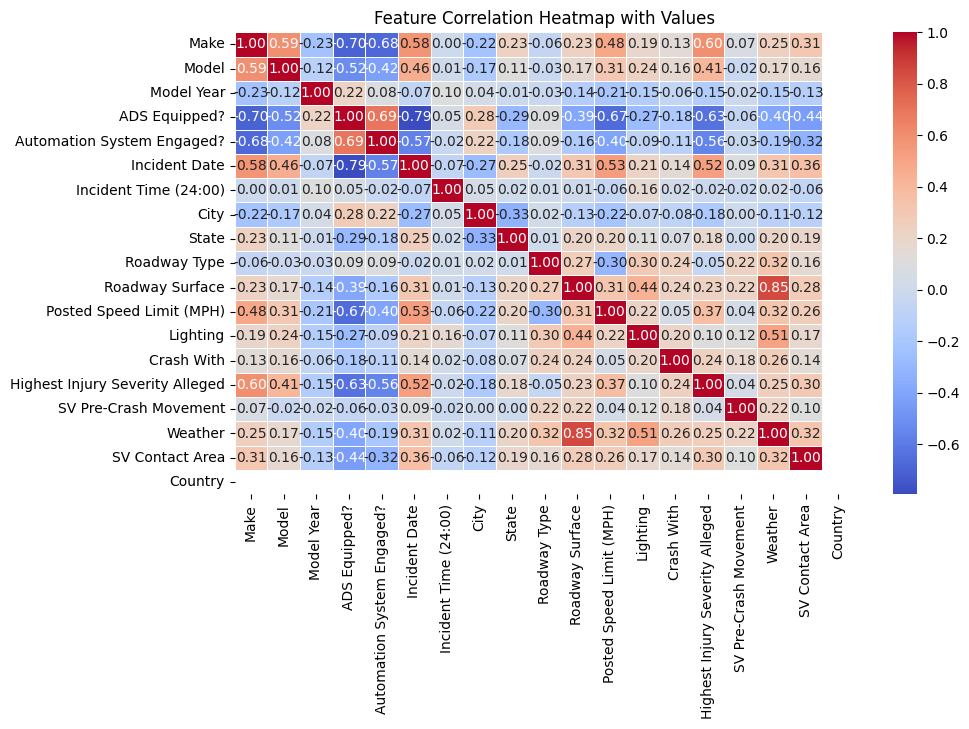

Top 10 most correlated features with 'Highest Severity Injury Alleged':
ADS Equipped?                 0.633698
Make                          0.599289
Automation System Engaged?    0.556943
Incident Date                 0.524662
Model                         0.406450
Posted Speed Limit (MPH)      0.368247
SV Contact Area               0.298180
Weather                       0.252102
Crash With                    0.237404
Roadway Surface               0.229196
Name: Highest Injury Severity Alleged, dtype: float64
Filtered dataset shape: (874, 10)


In [106]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# STEP 5: Now you can compute correlation safely
data_copy = systematic_sample_df
correlations = data_copy.corr()['Highest Injury Severity Alleged'].abs().dropna().sort_values(ascending=False)


# Plot heatmap with correlation values
plt.figure(figsize=(10, 6))
sns.heatmap(data_copy.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap with Values")
plt.show()


# STEP 6: Top 10 most correlated (excluding the target itself)
most_correlated_features = correlations.iloc[1:11]
print("Top 10 most correlated features with 'Highest Severity Injury Alleged':")
print(most_correlated_features)

# Filter dataset to top features
data_filtered = data_copy[most_correlated_features.index]
print("Filtered dataset shape:", data_filtered.shape)
